## Reproduce results of Scheme B

Paper: "Statistical supervised meta-ensemble algorithm for data linkage"

Kha Vo, Jitendra Jonnagaddala, Siaw-Teng Liaw

February 2019

Jounal of Biomedical Informatics

In [1]:
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold

In [2]:
from utils import (
    generate_true_links,
    generate_false_links,
    swap_fields_flag,
    join_names_space,
    join_names_dash,
    abb_surname,
    reset_day,
    set_random_seed
)
from training_utils import train_model, classify, evaluation, blocking_performance

In [3]:
set_random_seed()

In [4]:
trainset = 'ePBRN_dup_train' 
testset = 'ePBRN_dup_test'

In [5]:
## I did not touch these yet b/c there are differences
## - Andrew
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')      
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df,train_true_links):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y


In [18]:
## TRAIN SETS CONSTRUCTION
def _GetXTrain_YTrain(frac):
    df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
    match_ids = set(df_train['match_id'])
    for id_ in match_ids:
        filtered_df = df_train[df_train['match_id'] == id_]
        if filtered_df.shape[0] == 1:
            continue
        if np.random.random() < frac:
            df_train[df_train['match_id'] == id_] = filtered_df.head(1)
    train_true_links = generate_true_links(df_train)
    print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

    # Preprocess train set
    df_train['postcode'] = df_train['postcode'].astype(str)

    # Final train feature vectors and labels
    return generate_train_X_y(df_train, train_true_links)

frac_of_duplicates_to_remove = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.85, 0.95]
X_trains = []
y_trains = []


In [20]:
x, y = _GetXTrain_YTrain(frac=0.0)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:03<00:00, 3599.53it/s]


Train set size: 14078 , number of matched pairs:  3192


100%|██████████| 3192/3192 [00:02<00:00, 1350.42it/s]


In [23]:
x, y = _GetXTrain_YTrain(frac=0.1)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 3797.67it/s]


Train set size: 14078 , number of matched pairs:  2848


100%|██████████| 2848/2848 [00:02<00:00, 1324.94it/s]


In [24]:
x, y = _GetXTrain_YTrain(frac=0.25)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 3738.74it/s]


Train set size: 14078 , number of matched pairs:  2387


100%|██████████| 2387/2387 [00:01<00:00, 1286.46it/s]


In [25]:
x, y = _GetXTrain_YTrain(frac=0.4)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4642.01it/s]


Train set size: 14078 , number of matched pairs:  1866


100%|██████████| 1866/1866 [00:01<00:00, 1496.39it/s]


In [26]:
x, y = _GetXTrain_YTrain(frac=0.5)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4695.71it/s]


Train set size: 14078 , number of matched pairs:  1608


100%|██████████| 1608/1608 [00:01<00:00, 1514.90it/s]


In [27]:
x, y = _GetXTrain_YTrain(frac=0.6)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4745.69it/s]


Train set size: 14078 , number of matched pairs:  1287


100%|██████████| 1287/1287 [00:00<00:00, 1412.89it/s]


In [28]:
x, y = _GetXTrain_YTrain(frac=0.75)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4521.21it/s]


Train set size: 14078 , number of matched pairs:  772


100%|██████████| 772/772 [00:00<00:00, 1470.43it/s]


In [29]:
x, y = _GetXTrain_YTrain(frac=0.85)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4801.32it/s]


Train set size: 14078 , number of matched pairs:  466


100%|██████████| 466/466 [00:00<00:00, 1442.70it/s]


In [30]:
x, y = _GetXTrain_YTrain(frac=0.95)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4922.08it/s]


Train set size: 14078 , number of matched pairs:  172


100%|██████████| 172/172 [00:00<00:00, 1387.83it/s]


In [31]:
# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
    block_indexer = rl.BlockIndex(on=field)
    candidates = block_indexer.index(df_test)
    # Comment(alecmori): This only takes two arguments, I think it's these two.
    # detects = blocking_performance(candidates, test_true_links, df_test)
    detects = blocking_performance(candidates, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

# Comment(alecmori): This only takes two arguments, I think it's these two.
# detects = blocking_performance(candidates, test_true_links, df_test)
detects = blocking_performance(candidates, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...


100%|██████████| 9251/9251 [00:02<00:00, 3544.87it/s]


Test set size: 11731 , number of matched pairs:  2653
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 252552 , detected  1567 /2653 true matched pairs, missed 1086
Number of pairs of matched surname: 33832 , detected  1480 /2653 true matched pairs, missed 1173
Number of pairs of matched postcode: 79940 , detected  2462 /2653 true matched pairs, missed 191
Number of pairs of at least 1 field matched: 362910 , detected  2462 /2653 true matched pairs, missed 191


In [32]:
## TEST SET CONSTRUCTION

# Preprocess test set
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 360311, 1: 2599})
Finished building X_test, y_test


In [40]:
## BASE LEARNERS CLASSIFICATION AND EVALUATION
# Choose model
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['rbf', 'relu', 'l2']
modelparams = [0.001, 100, 0.005]
precision = []
sensitivity = []
Fscore = []
nb_false = []
fracs = []

for frac, X_train, y_train in zip(frac_of_duplicates_to_remove, X_trains, y_trains):
    for modeltype, modeltype_2, modelparam in zip(modeltypes, modeltypes_2, modelparams):
        print(f'Training {modeltype}, {modeltype_2}: {modelparam}')
        md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)
        precision += [final_eval['precision']]
        sensitivity += [final_eval['sensitivity']]
        Fscore += [final_eval['F-score']]
        nb_false  += [final_eval['no_false']]
        fracs.append(frac)
    
print("No_false:",nb_false,"\n")
print("Precision:",precision,"\n")
print("Sensitivity:",sensitivity,"\n")
print("F-score:", Fscore,"\n")
print(f"Fracs: {fracs}")
print("")

Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 100
Training lg, l2: 0.005
No_false: [5486, 23686, 1758, 4294, 19799, 1742, 3177, 15336, 1658, 2349, 9804, 1599, 2023, 3367, 1462, 2145, 3454, 1500, 2045, 2327, 1409, 1925, 1355, 1157, 2376, 1233, 1209] 

Precision: [0.3198102608912745, 0.09777591271506504, 0.6003340491529467, 0.37505528527200355, 0.11452263558942179, 0.6028811524609844, 0.4488495575221239, 0.14308132040576135, 0.61534

In [36]:
N = int(len(fracs) / 3)

Text(0.5, 1.0, 'Best SVM Performance')

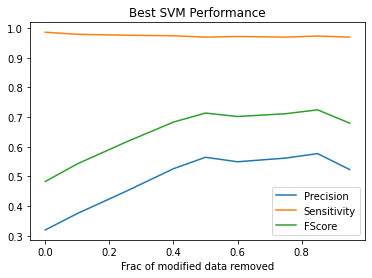

In [41]:
import matplotlib.pyplot as plt


plt.plot(
    [fracs[i * 3] for i in range(N)],
    [precision[i * 3] for i in range(N)],
)

plt.plot(
    [fracs[i * 3] for i in range(N)],
    [sensitivity[i * 3] for i in range(N)],
)

plt.plot(
    [fracs[i * 3] for i in range(N)],
    [Fscore[i * 3] for i in range(N)],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best SVM Performance')

Text(0.5, 1.0, 'Best NN Performance')

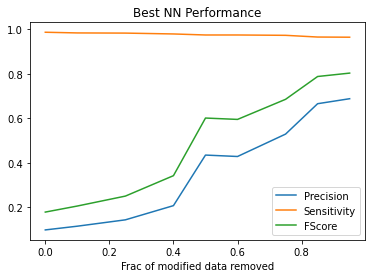

In [42]:
import matplotlib.pyplot as plt

plt.plot(
    [fracs[i * 3 + 1] for i in range(N)],
    [precision[i * 3 + 1] for i in range(N)],
)

plt.plot(
    [fracs[i * 3 + 1] for i in range(N)],
    [sensitivity[i * 3 + 1] for i in range(N)],
)

plt.plot(
    [fracs[i * 3 + 1] for i in range(N)],
    [Fscore[i * 3 + 1] for i in range(N)],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best NN Performance')

Text(0.5, 1.0, 'Best LG Performance')

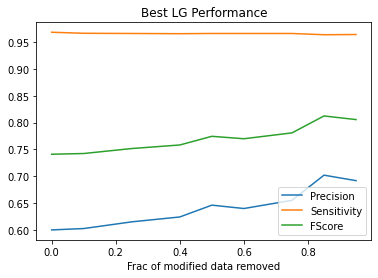

In [43]:
import matplotlib.pyplot as plt

plt.plot(
    [fracs[i * 3 + 2] for i in range(N)],
    [precision[i * 3 + 2] for i in range(N)],
)

plt.plot(
    [fracs[i * 3 + 2] for i in range(N)],
    [sensitivity[i * 3 + 2] for i in range(N)],
)

plt.plot(
    [fracs[i * 3 + 2] for i in range(N)],
    [Fscore[i * 3 + 2] for i in range(N)],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best LG Performance')

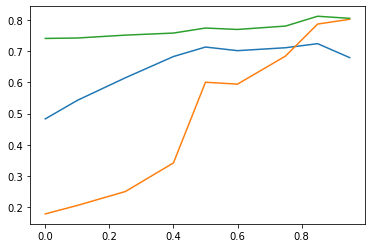

In [44]:
plt.plot(
    [fracs[i * 3] for i in range(N)],
    [Fscore[i * 3] for i in range(N)],
)


plt.plot(
    [fracs[i * 3 + 1] for i in range(N)],
    [Fscore[i * 3 + 1] for i in range(N)],
)


plt.plot(
    [fracs[i * 3 + 2] for i in range(N)],
    [Fscore[i * 3 + 2] for i in range(N)],
)
plt.legend(['SVM', 'NN', 'LG'])
plt.xlabel('Frac of modified data removed')
plt.ylabel('F-Score')
plt.title('Performance of Model With Best Hyper')